In [1]:
%load_ext autoreload
%autoreload 2
import cmcrameri.cm as cm  # Importing the cmcrameri colormaps
%run ct_data.py '../crunchtope_model/results.nc' -c volume
%run pf_data.py '../pflotran_model/little_dev_model/chem_model.h5'

Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Epidote', 'Zoisite', 'Chamosite-7A', 'Clinochlore-7A', 'Analcime', 'Anhydrite', 'Calcite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite-7A', 'Clinochlore-7A'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'serpentinites': ['Talc'], 'epidotes': ['Epidote', 'Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite']}
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Talc', 'Quartz', 'Saponite_Mg', 'Epidote', 'Zoisite', 'Chamosite-7A', 'Clinochlore-7A', 'Analcime', 'Anhydrite', 'Calcite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'],

In [2]:
# Parameters
basecase = 4
time = 1000

In [3]:
def stack_plot(ax, ds, variable_groups, custom_cycler, crunchtope=False):
    import numpy as np

    variables = []
    for variable_group in variable_groups: 
        for minerals in variable_group.keys():
            if crunchtope:
                variables.extend([minerals])
            else:
                variables.extend([minerals + "_VF"])

    # Condition to sum over a part of the domain, based on another variable 'condition_var'
    # For example, let's sum where 'condition_var' is greater than a threshold value

    ax.set_prop_cycle(custom_cycler)
    
    threshold = 10
    condition = ds['percentage_alteration'].sel(time=time) > threshold

    if crunchtope:
        dims=['X', 'Z', 'Y']
    else:
        dims=['x', 'z', 'y']

    normalised = condition.sum(dim=dims) * 0.9
    # Calculate the sum of each variable over the specified condition
    sums = {}
    for var in variables:
        sums[var] = ds[var].where(condition).sum(dim=dims) / normalised * 100 # Assuming 'x' and 'y' are spatial dimensions

    # Convert the sums into a stack plot
    # Assuming 'time' is the dimension you want to plot over
    stack_data = np.vstack([sums[var].values for var in variables])
    ax.stackplot(ds['time'] / time, stack_data, labels=variables)

    return ax

/tmp/ipykernel_326982/3186130438.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


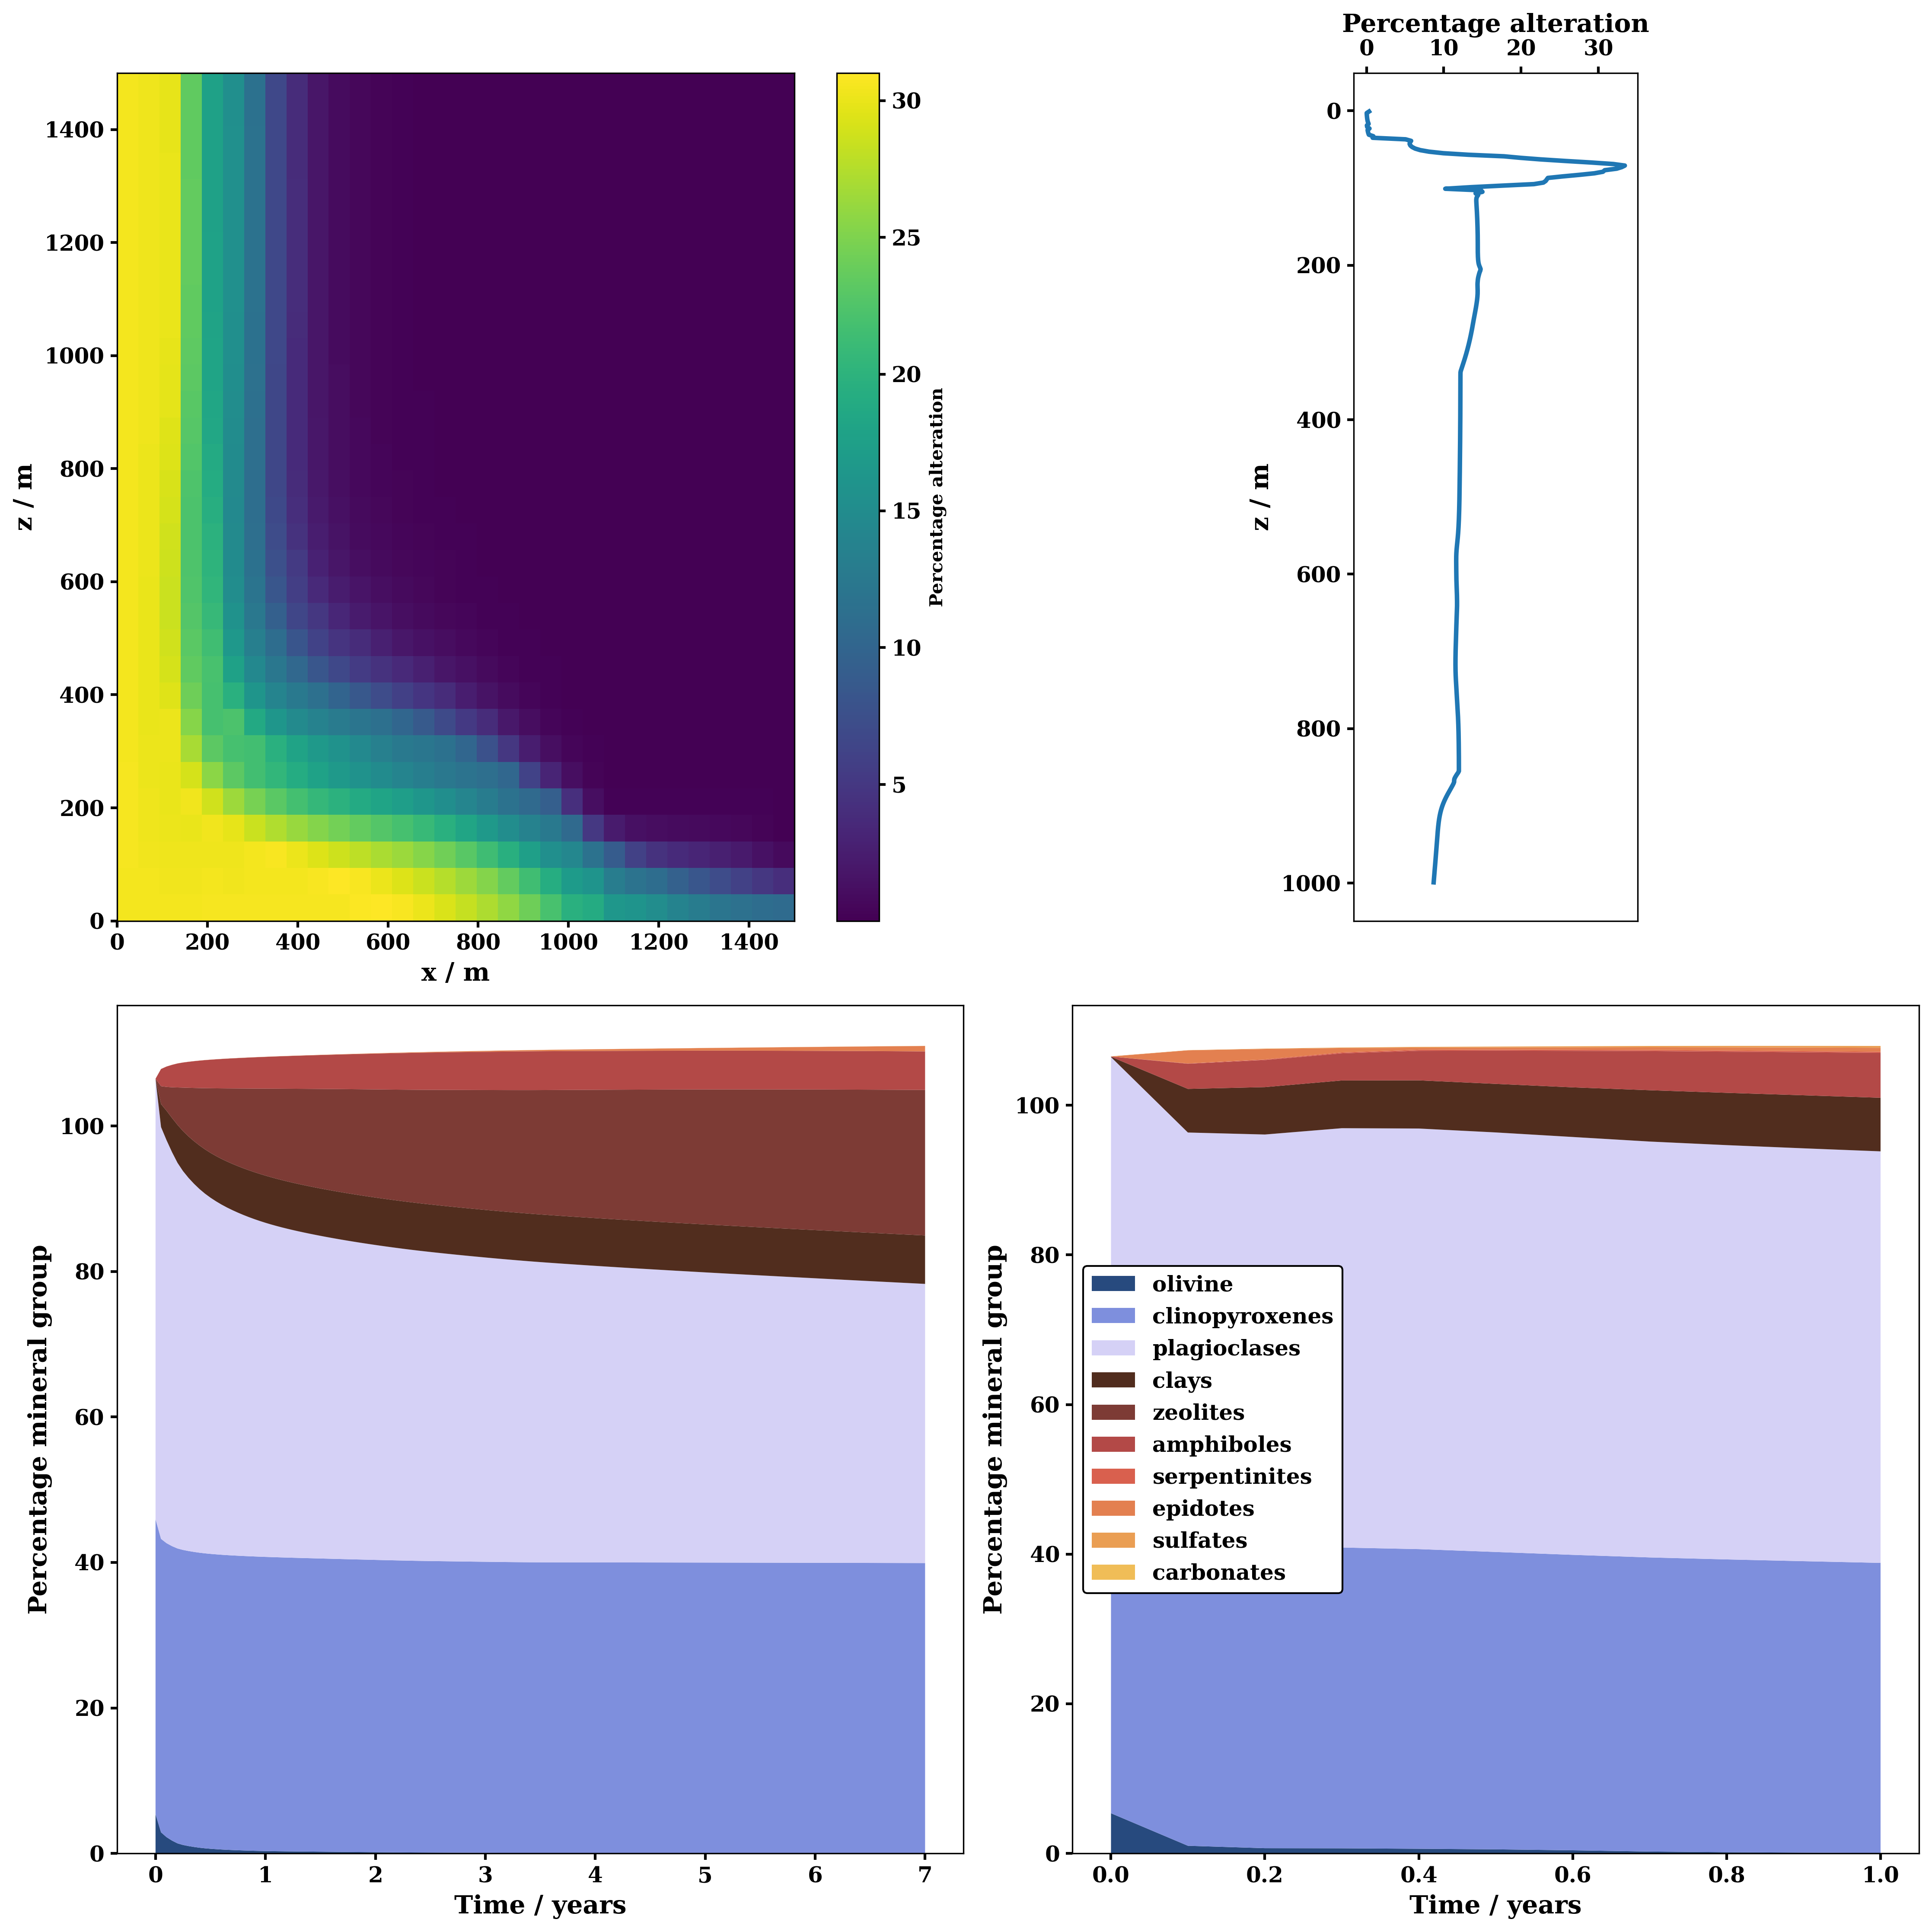

In [14]:
from matplotlib import pyplot as plt
from matplotlib import cycler
import numpy as np
plt.style.use('custom.mplstyle')
import figures as figs
fontsize = 14

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()

# PF alteration
# Plotting the variable using matplotlib and a colormap
mesh = ax[0].pcolormesh(pf_data['x'], pf_data['z'], pf_data['percentage_alteration'].sel(time=time).squeeze(), cmap='viridis', shading='auto')
#ax[0].colorbar(label='Value')  # Adds a color bar with label
ax[0].set_xlabel('x / m', fontsize=fontsize)
ax[0].set_ylabel('z / m', fontsize=fontsize)
# Create an image on the main axis
# Add colorbar to the created axis
fig.colorbar(mesh, ax=ax[0], label='Percentage alteration')

# CT alteration
ct_cat = ct_data['volume']
ax[1].plot(ct_cat['percentage_alteration'].sel(time=time, file_num=basecase).squeeze(), ct_cat['X'] )
ax[1].set_xlabel('Percentage alteration', fontsize=fontsize)
ax[1].set_ylabel('z / m', fontsize=fontsize)
figs.axis_to_depth_profile(ax[1])

# Select a sequential colormap from cmcrameri
# Define the number of groups (or layers) in the stack plot
# Extract colors from the colormap
colors_cool = cm.devon(np.linspace(0.2, 0.8, len(primary_mineral_groups)))
colors_hot = cm.lajolla(np.linspace(0.2, 0.8, len(secondary_mineral_groups)))  
colors = np.vstack((colors_cool, colors_hot))
# Create a custom color cycler using the extracted colors
custom_cycler = cycler(color=colors)

stack_plot(ax[2], pf_data, [primary_mineral_groups, secondary_mineral_groups], custom_cycler)
ax[2].set_xlabel('Time / years', fontsize=fontsize)
ax[2].set_ylabel('Percentage mineral group', fontsize=fontsize)
stack_plot(ax[3], ct_cat.sel(file_num=basecase), [primary_mineral_groups, secondary_mineral_groups], custom_cycler, crunchtope=True)
ax[3].set_xlabel('Time / years', fontsize=fontsize)
ax[3].set_ylabel('Percentage mineral group', fontsize=fontsize)
ax[3].legend(loc=6)

fig.tight_layout()
fig.show()